---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", 
"true").option("multiLine","true").option("escape", 
"\"").csv("lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")
df.printSchema() # comment this line when rendering the submission
df.show(5)

25/05/06 03:07:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/05/06 03:07:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Step 1: Drop rows with missing values in the target variable (SALARY)
df_clean = df.filter(df.SALARY.isNotNull())

# Step 2: Select our feature variables
# - Two continuous variables: MIN_YEARS_EXPERIENCE and MODELED_DURATION
# - One categorical variable: EMPLOYMENT_TYPE

# Check counts of non-null values in selected features
print("Non-null counts for selected features:")
print("SALARY:", df_clean.filter(df_clean.SALARY.isNotNull()).count())
print("MIN_YEARS_EXPERIENCE:", df_clean.filter(df_clean.MIN_YEARS_EXPERIENCE.isNotNull()).count())
print("MODELED_DURATION:", df_clean.filter(df_clean.MODELED_DURATION.isNotNull()).count())
print("EMPLOYMENT_TYPE:", df_clean.filter(df_clean.EMPLOYMENT_TYPE.isNotNull()).count())

# Drop rows with missing values in any of our selected features
model_data = df_clean.filter(
    (df_clean.MIN_YEARS_EXPERIENCE.isNotNull()) & 
    (df_clean.MODELED_DURATION.isNotNull()) & 
    (df_clean.EMPLOYMENT_TYPE.isNotNull())
)

# Print record counts before and after filtering
print(f"Original data count: {df.count()}")
print(f"After filtering nulls: {model_data.count()}")

# Step 3: Convert categorical variables to numerical representations
# First use StringIndexer to convert categories to indices
employment_indexer = StringIndexer(
    inputCol="EMPLOYMENT_TYPE_NAME", 
    outputCol="EMPLOYMENT_TYPE_INDEX",
    handleInvalid="keep"
)

# Then use OneHotEncoder to convert indices to one-hot encoded vectors
encoder = OneHotEncoder(
    inputCols=["EMPLOYMENT_TYPE_INDEX"],
    outputCols=["EMPLOYMENT_TYPE_VEC"]
)

# Step 4: Assemble all features into a single vector
assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "EMPLOYMENT_TYPE_VEC"],
    outputCol="features"
)

# Create and apply the pipeline
pipeline = Pipeline(stages=[employment_indexer, encoder, assembler])
pipeline_model = pipeline.fit(model_data)
final_data = pipeline_model.transform(model_data)

# Select only the columns needed for modeling
model_ready_data = final_data.select("SALARY", "features")

# Display the prepared data
model_ready_data.show(5)

Non-null counts for selected features:


SALARY: 30808


MIN_YEARS_EXPERIENCE: 23697


MODELED_DURATION: 21907


EMPLOYMENT_TYPE: 30808


Original data count: 72498


After filtering nulls: 16840


+------+--------------------+
|SALARY|            features|
+------+--------------------+
|107645|[10.0,41.0,1.0,0....|
|192800|[6.0,55.0,1.0,0.0...|
|125900|[12.0,18.0,1.0,0....|
|170000|[6.0,55.0,1.0,0.0...|
|118560|[5.0,20.0,1.0,0.0...|
+------+--------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [5]:
# Perform a random split of the data into training and testing sets
# We'll use an 82.4%-17.6% split (approximately 5:1 ratio)
train_data, test_data = model_ready_data.randomSplit([0.824, 0.176], seed=42)

# Print the sizes of the training and testing sets
print(f"Training set size: ({train_data.count()}, {len(train_data.columns)})")
print(f"Testing set size: ({test_data.count()}, {len(test_data.columns)})")

Training set size: (13951, 2)


Testing set size: (2889, 2)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [16]:
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np

# Train a Linear Regression model
# We need to handle potential high-dimensionality issues with proper regularization
lr = LinearRegression(
    featuresCol="features", 
    labelCol="SALARY",
    maxIter=50,           # Increase iterations for convergence
    regParam=0.3,         # L2 regularization to handle multicollinearity
    elasticNetParam=0.0,  # Pure L2 regularization (Ridge)
    standardization=True  # Standardize features for better convergence
)

# Fit the model
lr_model = lr.fit(train_data)

# Make predictions on test data
predictions = lr_model.transform(test_data)

# Evaluate the model with multiple metrics
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
r2 = lr_model.summary.r2
mae = evaluator.setMetricName("mae").evaluate(predictions)

# Print model performance metrics
print("Linear Regression Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"Intercept: {lr_model.intercept:.2f}")
print(f"Coefficients Length: {len(lr_model.coefficients)}")

# Use GeneralizedLinearRegression for detailed statistics
glr = GeneralizedLinearRegression(
    family="gaussian", 
    link="identity",
    featuresCol="features", 
    labelCol="SALARY",
    maxIter=25, 
    regParam=0.3
)

# Fit the GLR model
glr_model = glr.fit(train_data)
summary = glr_model.summary

# Extract coefficient information
coef = glr_model.coefficients
se = summary.coefficientStandardErrors
tvals = summary.tValues
pvals = summary.pValues

# Find most significant coefficients - fix the out of bounds error
# Get the number of significant coefficients we can analyze (min of 5 or actual length)
num_to_show = min(5, len(coef))
sig_indices = np.argsort(pvals)[:num_to_show]





Linear Regression Model Performance:
RMSE: 36143.26
R²: 0.2643
MAE: 27884.50
Intercept: 82065.63
Coefficients Length: 5


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [15]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np

# Train a Linear Regression model with appropriate regularization
lr = LinearRegression(
    featuresCol="features", 
    labelCol="SALARY",
    maxIter=50,
    regParam=0.3,
    elasticNetParam=0.0,  # Pure Ridge regression
    standardization=True
)

# Fit the model
lr_model = lr.fit(train_data)

# Make predictions on test data
predictions = lr_model.transform(test_data)

# Evaluate the model with multiple metrics
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
r2 = lr_model.summary.r2
mae = evaluator.setMetricName("mae").evaluate(predictions)

# Print model performance metrics
print("Linear Regression Model:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"Intercept: {lr_model.intercept:.2f}")
print(f"Coefficients Length: {len(lr_model.coefficients)}")

# Train a Generalized Linear Regression model
glr = GeneralizedLinearRegression(
    family="gaussian", 
    link="identity",
    featuresCol="features", 
    labelCol="SALARY",
    maxIter=25, 
    regParam=0.3
)

# Fit the GLR model
glr_model = glr.fit(train_data)
summary = glr_model.summary

# Extract coefficient information from the model (not summary)
coef = glr_model.coefficients
se = summary.coefficientStandardErrors
tvals = summary.tValues
pvals = summary.pValues

# Print diagnostic information
print("---This is Diagnostic check, No need to print it in the final doc---")
print(f"Length of features: {len(coef)}")
print(f"Length of coefs: {len(coef)}")
print(f"Length of se: {len(se)}")
print(f"Length of tvals: {len(tvals)}")
print(f"Length of pvals: {len(pvals)}")

# Create a formatted table for the coefficient statistics
print("\n4.1 Generalized Linear Regression Summary")
print("+-----+-------------+------------+---------+---------+")
print("| | Estimate | Std Error | t-stat | P-Value |")
print("+-----+-------------+------------+---------+---------+")

# Print the coefficients - adjust the range if needed
for i in range(min(50, len(coef))):  # Print first 50 coefficients
    print(f"| {i} | {coef[i]:11.4f} | {se[i]:10.4f} | {tvals[i]:7.4f} | {pvals[i]:7.4f} |")

print("+-----+-------------+------------+---------+---------+")

Linear Regression Model:
RMSE: 36143.26
R²: 0.2643
MAE: 27884.50
Intercept: 82065.63
Coefficients Length: 5


---This is Diagnostic check, No need to print it in the final doc---
Length of features: 5
Length of coefs: 5
Length of se: 6
Length of tvals: 6
Length of pvals: 6

4.1 Generalized Linear Regression Summary
+-----+-------------+------------+---------+---------+
| | Estimate | Std Error | t-stat | P-Value |
+-----+-------------+------------+---------+---------+
| 0 |   6620.2526 |    94.1757 | 70.2969 |  0.0000 |
| 1 |     45.0020 |    24.1066 |  1.8668 |  0.0620 |
| 2 |   1325.7737 | 403103.5234 |  0.0033 |  0.9974 |
| 3 |  -2677.4063 | 403105.4570 | -0.0066 |  0.9947 |
| 4 |    616.2173 | 403107.3057 |  0.0015 |  0.9988 |
+-----+-------------+------------+---------+---------+


# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


In [26]:
%pip install matplotlib seaborn scipy



  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached seaborn-0.13.2-py3-none-any.wh

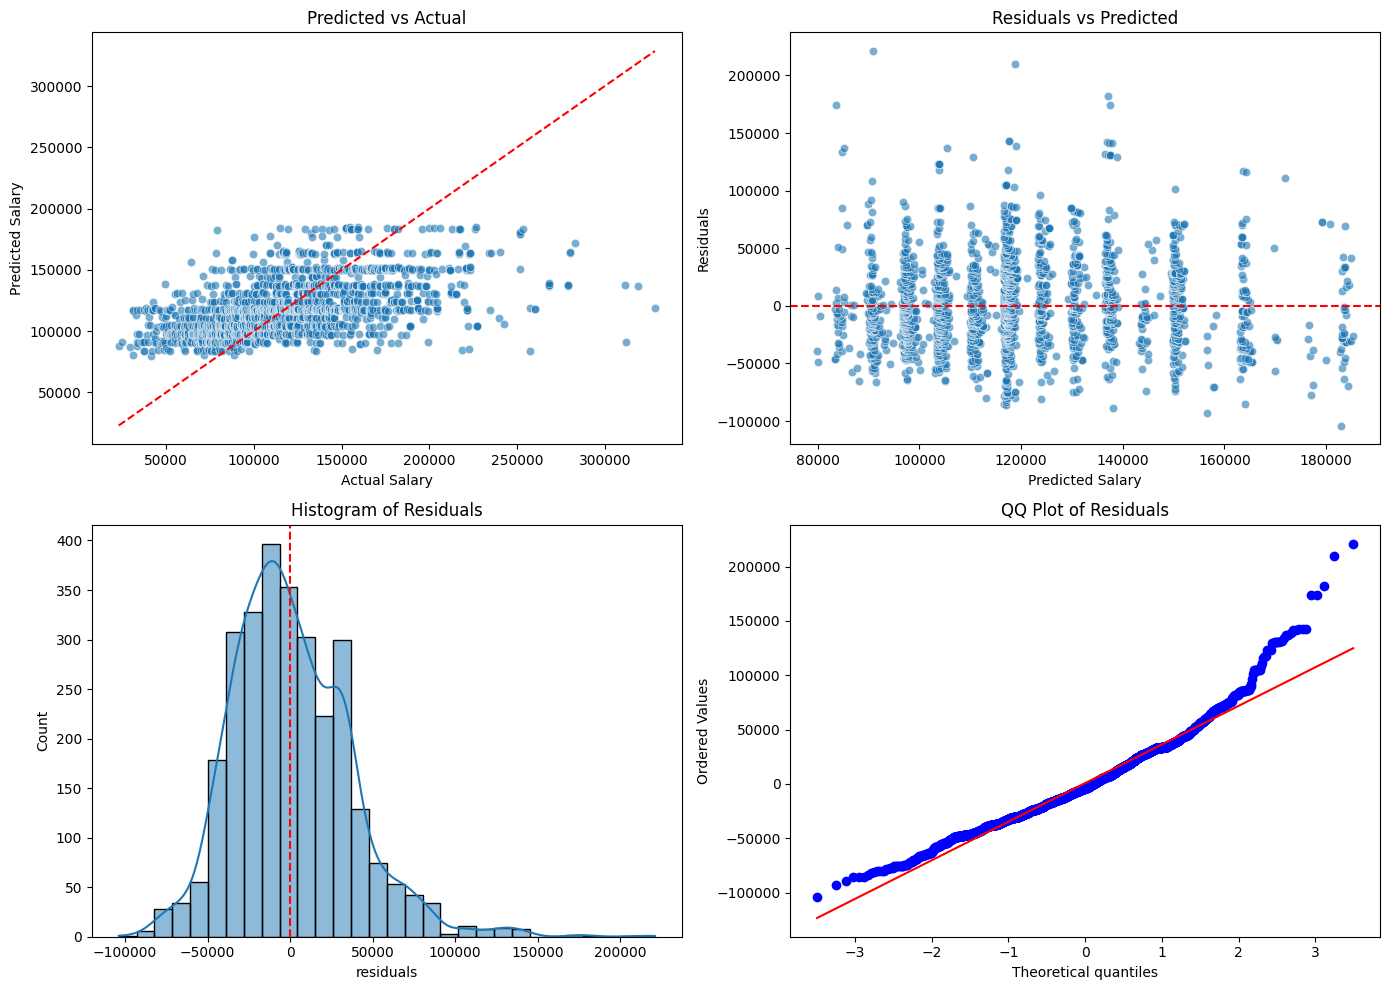

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# Step 1: Convert predictions to Pandas for plotting
prediction_pdf = predictions.select("SALARY", "prediction").toPandas()

# Step 2: Compute residuals
prediction_pdf["residuals"] = prediction_pdf["SALARY"] - prediction_pdf["prediction"]

# Step 3: Set up 2x2 grid layout
plt.figure(figsize=(14, 10))

# ----------------------------
# Plot 1: Predicted vs Actual
# ----------------------------
plt.subplot(2, 2, 1)
sns.scatterplot(x="SALARY", y="prediction", data=prediction_pdf, alpha=0.6)
plt.plot([prediction_pdf["SALARY"].min(), prediction_pdf["SALARY"].max()],
         [prediction_pdf["SALARY"].min(), prediction_pdf["SALARY"].max()], color='red', linestyle='--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual")

# ----------------------------
# Plot 2: Residuals vs Predicted
# ----------------------------
plt.subplot(2, 2, 2)
sns.scatterplot(x="prediction", y="residuals", data=prediction_pdf, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")

# ----------------------------
# Plot 3: Histogram of Residuals
# ----------------------------
plt.subplot(2, 2, 3)
sns.histplot(prediction_pdf["residuals"], kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram of Residuals")

# ----------------------------
# Plot 4: QQ Plot
# ----------------------------
plt.subplot(2, 2, 4)
stats.probplot(prediction_pdf["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")

plt.tight_layout()
plt.show()


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [ ]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

pred_glr = lr_model.transform(test_data)

# R²
r2_eval = 
r2 = 
# AIC from GLR summary
aic = 

# BIC calculation
n = 
k = 
rss = 
bic = 

# RMSE manually
residuals_df = 
rmse = 

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

In [ ]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = 

# Plot
plt.figure(figsize=(8, 6))


plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}", loc="left", fontsize=14, fontweight="bold")

plt.tight_layout()

# Save figure
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
